## Decision Surfaces

Im Folgenden verwenden wir eine visuelle Unterstützung, um zu zeigen, wie Hypothesen von verschiedenen Klassifikationsalgorithmen Instanzen klassifizieren: das *Decision Surface*. Bei einem Decision Surface handelt es sich um eine geometrische Interpretation von Klassifikationsergebnissen. Der Raum der Instanzen wird in verschiedene Regionen aufgeteilt, sodass jede Region die Instanzen gleich klassifiziert. Bei zweidimensionalen Daten heißt das, dass man farbige Flächen zeichnen kann, wobei die Farben die Klassen repräsentieren. In höherdimensionalen Räumen kann man die Decision Surfaces leider nicht gut darstellen. Wir nutzen die Kelchblattlänge und Kelchblattbreite der Irisdaten (siehe [Kapitel 4](kapitel_04)) als Beispieldatensatz, um zu zeigen, wie die Klassifikationsalgorithmen arbeiten.

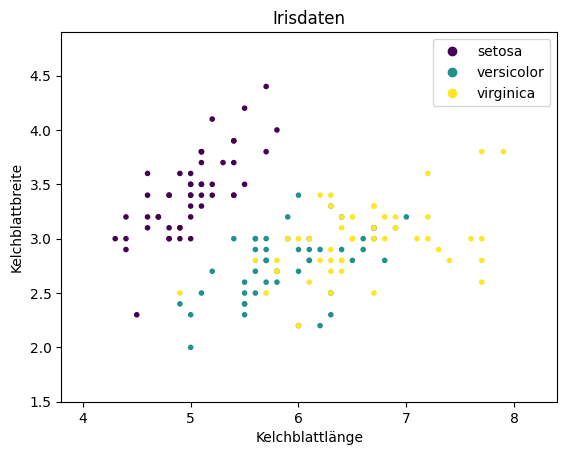

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris

X, Y = load_iris(as_frame=True, return_X_y=True)
class_names = load_iris().target_names.tolist()
X = X.iloc[:, 0:2] # use only first two columns from iris data
X = X.rename(columns={'sepal length (cm)': 'Kelchblattlänge',
                      'sepal width (cm)': 'Kelchblattbreite'})

fig, ax = plt.subplots()
ax.set_xlim(X.iloc[:,0].min() - .5, X.iloc[:,0].max() + .5)
ax.set_ylim(X.iloc[:,1].min() - .5, X.iloc[:,1].max() + .5)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1],c=Y, marker='.')
ax.set_xlabel(X.columns[0])
ax.set_ylabel(X.columns[1])
ax.set_title('Irisdaten')
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)
plt.show()

Man erkennt, dass die Setosas klar von den anderen Arten der Iris getrennt sind, während sich die Versicolor und Virginica überlappen. Wir nutzen jetzt die Hintergrundfarbe, um zu zeigen, wie ein Decision Surface aussieht: Lila für Setosa, Türkis für Versicolor und Gelb für Virginica. Als Beispiel definieren wir selbst Regeln zur Klassifikation:

- Alle Instanzen, deren Kelchblattlänge kleiner als 5,5 ist, werden als Setosa klassifiziert. 
- Alle Instanzen, deren Kelchblattlänge zwischen 5,5 und 6 liegt, werden als Versicolor klassifiziert. 
- Alle Instanzen, deren Kelchblattlänge größer als 6 ist, werden als Virginica klassifiziert. 

Hierdurch bekommen wir folgendes Decision Surface. 

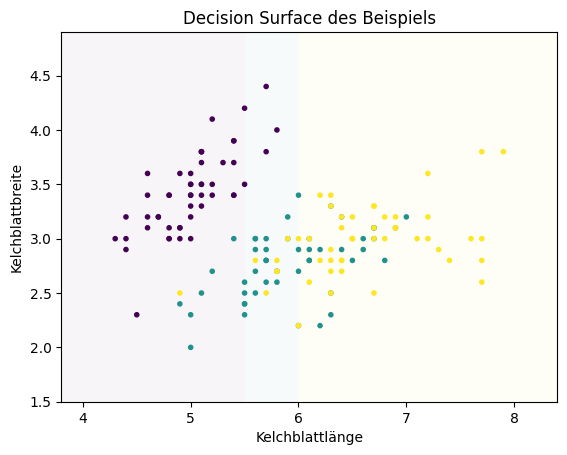

In [2]:
import numpy as np

class DummyModel:
    def fit(self, X, Y):
        pass
    
    def predict(self, X):
        result = np.ones(len(X)) # init everything as Versicolor
        result[X[:,0]<5.5] = 0 # rule for Setosa
        result[X[:,0]>6]   = 2 # rule for Virginica
        return result

def plot_decision_surface(model, X, Y, ax=None, title=None):
    h = .01 # step size in the mesh
    x_min, x_max = X.iloc[:,0].min() - .5, X.iloc[:,0].max() + .5
    y_min, y_max = X.iloc[:,1].min() - .5, X.iloc[:,1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    model.fit(X.values, Y)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    if ax is None:
        plt.figure()
        ax = plt.gca()
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.pcolormesh(xx, yy, Z, alpha=0.04, shading='auto')
    ax.scatter(X.iloc[:,0], X.iloc[:,1],c=Y, marker='.')
    
    ax.set_xlabel(X.columns[0])
    ax.set_ylabel(X.columns[1])
    if title is None:
        title = str(model)
    ax.set_title(title)
    
plot_decision_surface(DummyModel(), X, Y, title='Decision Surface des Beispiels')

Die Gerade, wo sich die Farbe ändert, nennt man *Decision Boundary*. Die Decision Boundaries bestimmen die Struktur der Ergebnisse und sind eine wesentliche Eigenschaft von Klassifikationsalgorithmen, die sowohl praktische Auswirkungen auf die Ergebnisse als auch ein wichtiges Hilfsmittel für die mathematische Beschreibung und Analyse ist.


Bei $k=1$ und $k=3$ wird dieser Punkt türkis markiert, da es zwei relativ nahe türkise Datenpunkte gibt, jedoch nur einen gelben. Bei $k=5$ wechselt der Punkt zur gelben Klasse, da es jetzt zwei weitere gelbe Punkte in der Nachbarschaft gibt. Bei $k=20$ sieht man, wie der Punkt zwar gelb bleibt, aber sehr viele Punkte mittlerweile mitbestimmen, obwohl die meisten davon sehr weit weg von unserem Datenpunkt liegen.

## Entscheidungsbäume

Stellen wir uns vor, dass wir uns ein Auto kaufen wollen. Als Käufer hat man in der Regel ein paar Kriterien, die man sich überlegt, bevor man zum Händler geht: Es sollte ein 5-Türer mit einer gewissen Leistung und einem gewissen Kofferraumvolumen sein. Manche dieser Kriterien sind wichtiger als andere, sie werden also zuerst angewandt, um Autos auszuschließen. Während die Anzahl der Türen fest steht, könnte es zum Beispiel bei der Leistung einen gewissen Spielraum geben. Dies ist die Intuition von *Entscheidungsbäumen* (engl. *decision tree*): Es werden schrittweise logische Regeln auf die Merkmale angewandt, um Entscheidungen zu treffen. Die Entscheidungen sind als Baum organisiert.

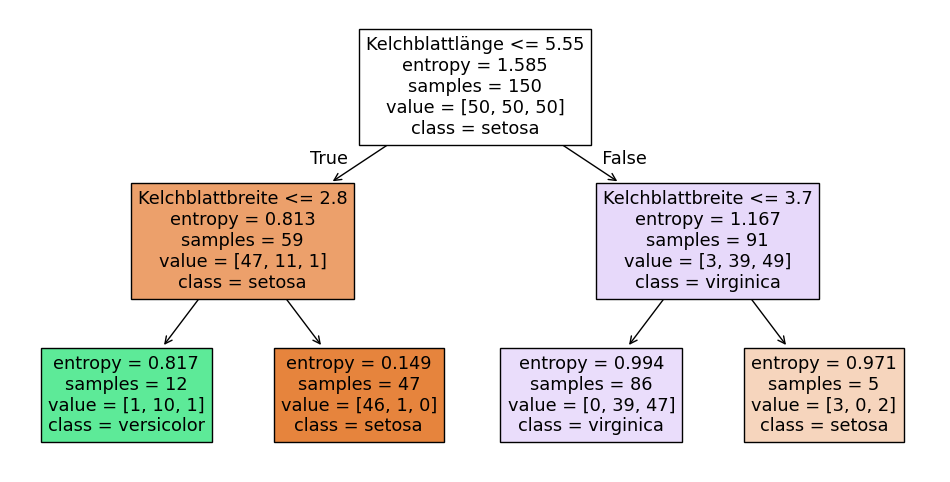

In [3]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier(criterion='entropy', max_depth=2)
clf.fit(X, Y)
plt.figure(figsize=(12,6))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=class_names)
plt.show()

In diesem Entscheidungsbaum wird als Erstes eine Entscheidung mithilfe der Kelchblattlänge getroffen. Ist diese kleiner oder gleich 5,55, gehen wir nach links, andernfalls nach rechts. Außerdem sieht man noch weitere Informationen. Das Feld `entropy` ignorieren wir fürs Erste. Der Wert von `samples` gibt an, wie viele Instanzen in den Trainingsdaten zur Verfügung standen, um diese Entscheidung zu lernen. Der Wert von `value` gibt an, wie viele Instanzen von jeder Klasse in `sample` enthalten sind. Bei `class` sieht man, welche Klassifikation man hätte, wenn man keine weiteren Entscheidungen trifft. Basierend auf der Entscheidung werden die Daten partitioniert: 59 Instanzen haben eine Kelchblattlänge, die kleiner oder gleich 5,55 ist, bei 91 Instanzen ist die Kelchblattlänge größer. Dies können wir an den `samples` in den Knoten auf der linken bzw. rechten Seite ablesen. Bei den 59 Instanzen auf der linken Seite sind es 47 Instanzen aus der ersten Klasse (Setosa), 11 Instanzen aus der zweiten Klasse (Versicolor) und 1 Instanz aus der dritten Klasse (Virginica). Auf der untersten Ebene (den Blättern des Baums) werden keine weiteren Entscheidungen getroffen.


Für die Interpretation eines Entscheidungsbaums braucht man weder Expertenwissen noch ein tiefes Verständnis der Daten selbst. Das ist auch der große Vorteil von Entscheidungsbäumen: Die Klassifikation ist nachvollziehbar und Domänenexpertinnen können durch manuelle Analyse die Plausibilität der Regeln bewerten.

Das Decision Surface des obigen Baums sieht wie folgt aus. 

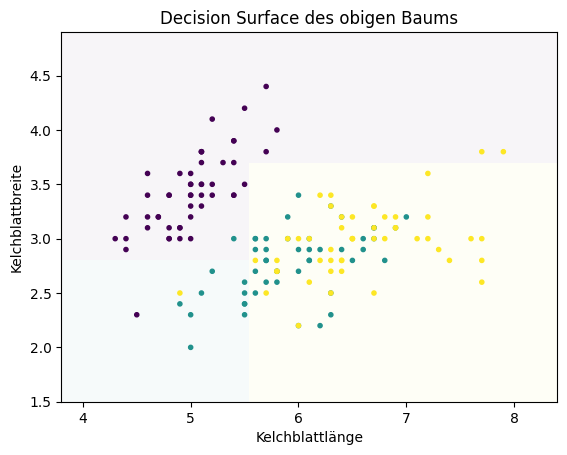

In [4]:
plot_decision_surface(clf, X, Y, title="Decision Surface des obigen Baums")
plt.show()

Wie man sieht, trennen die Decision Boundaries das Decision Surface durch achsenparallele Geraden. Dies ist eine Eigenschaft von Entscheidungsbäumen. Dadurch dass wir logische Entscheidungen der Form $\leq$ und $\geq$ (manchmal auch $=$) haben, werden die Daten durch jede Entscheidung in zwei Partitionen zerteilt, sodass die Entscheidung orthogonal zu einer Achse und parallel zu allen anderen Achsen ist.

Das Training von Entscheidungsbäumen basiert auf einem relativ einfachen rekursiven Algorithmus:

1. Beende den Algorithmus, wenn die Daten ausreichend "rein" sind, "zu klein" sind oder die maximale Tiefe des Entscheidungsbaums erreicht ist. 
2. Bestimme das "Merkmal mit dem höchsten Informationsgehalt" $X'$.
3. Partitioniere die Daten durch eine Regel für das Merkmal $X'$.
4. Wende den Algorithmus anfangend mit Schritt 1 rekursiv auf die Partionen an, um den linken und rechten Teilbaum zu erstellen. 

Wir müssen also nur das "Merkmal mit dem höchsten Informationsgehalt" finden, die Daten partitionieren und das so lange wiederholen, bis die Daten "rein" oder "zu klein" sind oder der Baum zu tief wird. Das Konzept von "zu klein" ist immer gleich: Die Anzahl der Instanzen in einer Partition unterschreitet einen vorher festgelegten Grenzwert. Durch dieses Kriterium können wir verhindern, dass Entscheidungen auf zu wenig Daten getroffen werden, und somit erzwingen, dass es für jede getroffene Entscheidung eine solide Datengrundlage gibt. Die maximale Tiefe beschränkt die Komplexität der Regeln. Die Tiefe des Baums ist definiert als die Anzahl der Entscheidungen, die getroffen werden, bevor die Klasse bestimmt wird. Der obige Baum hat zum Beispiel eine Tiefe von zwei. Zur Bestimmung der Reinheit, des Informationsgehalts und der Partitionen gibt es verschiedene Ansätze. Von diesen Ansätzen hängt auch ab, um was für eine Art von Entscheidungsbaum es sich handelt, zum Beispiel CART, ID3 oder C4.5.

Als Beispiel betrachten wir, wie man diese Konzepte durch die *Informationstheorie* definieren kann. Die Idee der Reinheit lässt sich informationstheoretisch durch die Unsicherheit der Daten fassen und der Informationsgehalt als die *gemeinsame Information* (engl. *mutual information*), durch die man den *Informationsgewinn* (engl. *information gain*) messen kann. Da sich die Informationstheorie mit Zufallsvariablen befasst, interpretieren wir hier alles als Zufallsvariablen: Die Klassifikation von Instanzen ist eine Zufallsvariable $C$ und unsere Merkmale sind die Zufallsvariablen $X_1, ..., X_m$. Das Kernkonzept der Informationstheorie ist die *Entropie*. Je höher die Entropie einer Zufallsvariablen ist, desto unsicherer und zufälliger ist der Ausgang eines Zufallsexperiments mit dieser Variablen. Die Entropie einer Zufallsvariablen, die einen fairen Münzwurf beschreibt (50% Kopf, 50% Zahl), ist zum Beispiel eins, der höchstmögliche Wert der Entropie. Die Entropie einer Zufallsvariablen für eine manipulierte Münze, die immer auf Kopf landet, hätte eine Entropie von null, es gäbe also keine Unsicherheit über das Ergebnis. Wenn wir somit Entscheidungen mit einer hohen Sicherheit treffen wollen, müssen wir Partitionen finden, sodass die Entropie der Klassifikation $C$ minimiert wird. Die Entropie von $C$ ist definiert als

$$H(C) = -\sum_{c \in C} p(c) \log p(c),$$

wobei $p(c)$ die Wahrscheinlichkeit ist, dass eine Instanz einer Partition zu Klasse $c$ gehört. Sobald die Entropie $H(C)$ unter einen Grenzwert fällt, ist die Entscheidung sicher genug und die Partition "rein". 

Die *bedingte Entropie* können wir nutzen, um abzuschätzen, wie viel Wissen über die Klasse wir durch ein Merkmal bekommen. Hierzu gibt die bedingte Entropie die Unsicherheit der Klasse $C$ an, wenn ein Merkmal $X'$ vollständig bekannt ist. Die Entropie der Klassifikation $C$ bezogen auf das Merkmal $X'$ ist definiert als

$$H(C|X') = -\sum_{x \in X'} p(x) \sum_{c \in C} p(c|x) \log p(c|x),$$


wobei $p(c|x)$ die bedingte Wahrscheinlichkeit der Klasse $c$ für einen Wert $x$ des Merkmals $X' \in \{X_1, ..., X_m\}$ ist. Die bedingte Entropie ist also ein Maß dafür, wie hoch der *Informationsgewinn* über $C$ mit $X'$ ist. Je niedriger die bedingte Entropie, desto höher der Informationsgewinn. Daher nennt man ein Merkmal *informativ*, wenn es die bedingte Entropie der Klassifikation reduziert. Wenn man die Entropie der Klassifikation mit der bedingten Entropie kombiniert, erhält man den *Informationsgewinn* durch die Reduktion der Entropie als 

$$I(C; X') = H(C)-H(C|X').$$

Das informativste Merkmal ist also das Merkmal, das den Informationsgewinn maximiert. Sobald man dieses Merkmal gefunden hat, kann man eine Regel bestimmen, sodass die mittlere Entropie der Klassifikation der Partitionen minimiert wird.

Oben haben wir bereits ein Decision Surface für einen Entscheidungsbaum mit einer niedrigen Tiefe von zwei betrachtet. Dies hat uns zwar geholfen, die Struktur von Entscheidungsbäumen und der Entscheidungen zu verstehen, es reicht jedoch in der Regel nicht aus, um ein gutes Ergebnis aus einem Datensatz zu erzielen. Hierfür benötigt man mehr Entscheidungen, also einen tieferen Entscheidungsbaum. Wenn wir die Tiefe nicht beschränken und keinen Grenzwert für zu wenige Daten, um eine Entscheidung zu treffen, angeben, bekommen wir folgendes Decision Surface.

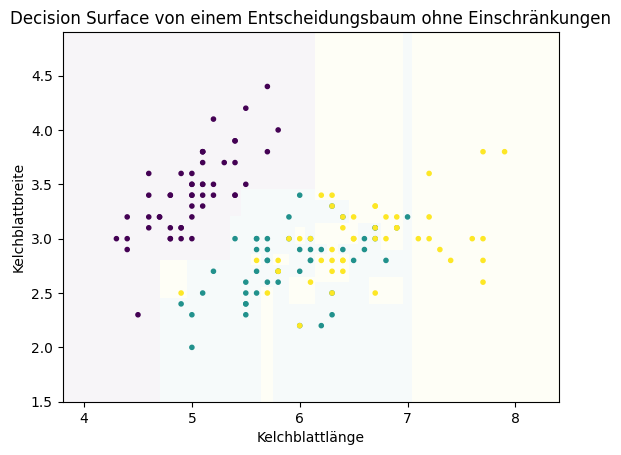

In [7]:
plot_decision_surface(DecisionTreeClassifier(), X, Y, title="Decision Surface von einem Entscheidungsbaum ohne Einschränkungen")
plt.show()

Man sieht, dass sehr viel mehr Entscheidungen getroffen werden: Jede achsenparallele Decision Boundary ist eine Entscheidung. Dies führt aber leider zu *Overfitting*, das heißt, es wurden einzelne Datenpunkte auswendig gelernt. Das erkennt man zum Beispiel an der kleinen gelben Fläche, die man etwa bei Kelchblattlänge sieben sieht. Hier liegt nur eine gelbe Instanz mitten in einer ansonsten türkisen Umgebung. Hierfür gibt es noch einige weitere Beispiele, etwa auch zwischen dem lila und dem türkisen Bereich. Um zu verhindert, dass so etwas passiert, müssen wir die erlaubten Entscheidungen beschränken. Wenn wir fordern, dass nur Partitionen mit mindestens fünf Instanzen erlaubt sind, verschwinden diese kleinen Bereiche.

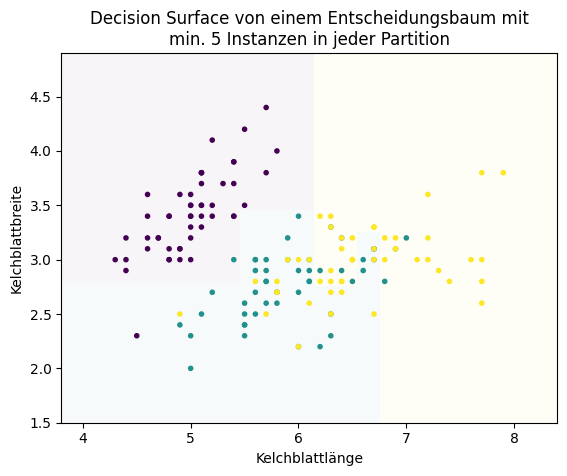

In [8]:
plot_decision_surface(DecisionTreeClassifier(min_samples_leaf=5), X, Y, title="Decision Surface von einem Entscheidungsbaum mit\nmin. 5 Instanzen in jeder Partition")
plt.show()

## Random Forests

Mit einem *Random Forest* kombiniert man viele Entscheidungsbäume zu einem Klassifikationsmodell. Die einzelnen Entscheidungsbäume nennt man *Random Tree*. Man spricht hierbei von *Ensemble Learning*, da der Random Forest ein Ensemble von Random Trees ist. Wie man aus vielen Entscheidungsbäumen die Klassifikation eines Random Forest erhält, sieht man im Folgenden.

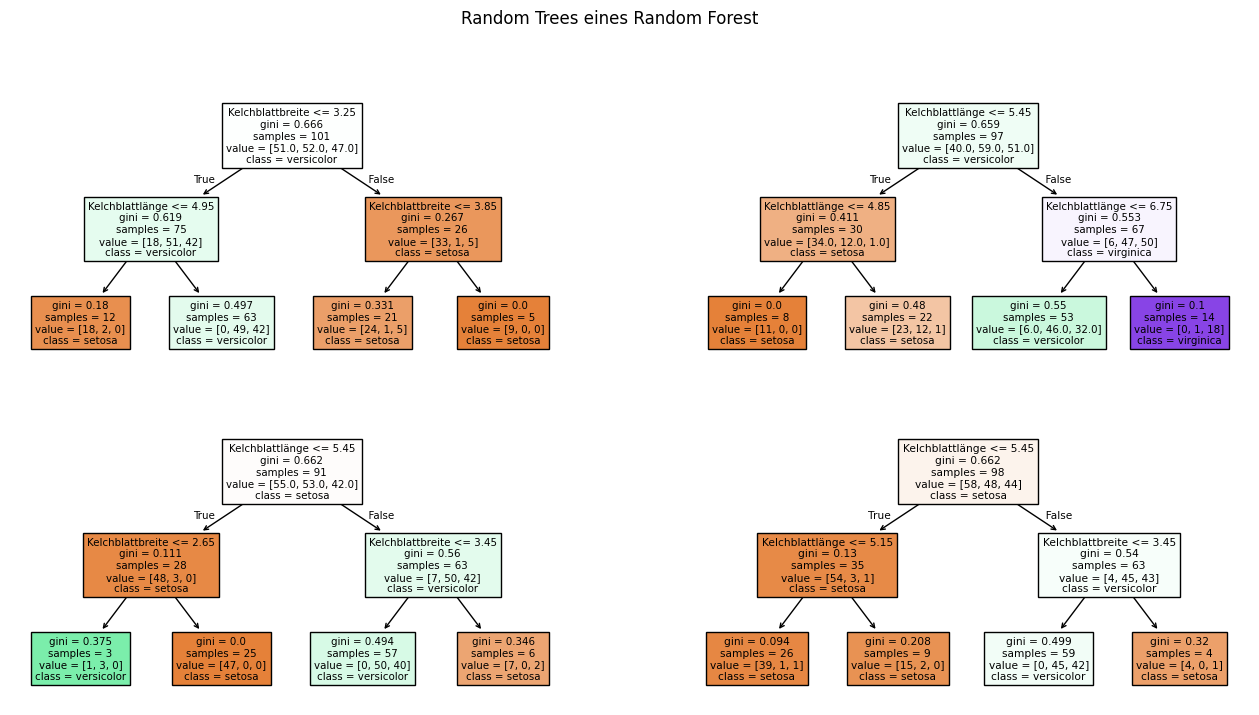

In [9]:
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier

# Please note that the parameters we use here are not good and should not be used
# for any real examples. We use only four random trees so that we can better demonstrate 
# the example. Usually, you should use hundreds of trees and more are better, but require
# more runtime (both for training and predictions). 
randomforest = RandomForestClassifier(n_estimators=4, max_depth=2, random_state=42)
randomforest.fit(X, Y)

f, axes = plt.subplots(2, 2, figsize=(16, 8))
plot_tree(randomforest.estimators_[0], filled=True, feature_names=X.columns, class_names=class_names, ax=axes[0,0])
plot_tree(randomforest.estimators_[1], filled=True, feature_names=X.columns, class_names=class_names, ax=axes[0,1])
plot_tree(randomforest.estimators_[2], filled=True, feature_names=X.columns, class_names=class_names, ax=axes[1,0])
plot_tree(randomforest.estimators_[3], filled=True, feature_names=X.columns, class_names=class_names, ax=axes[1,1])
plt.suptitle("Random Trees eines Random Forest")
plt.show()

Jeder einzelne Random Tree ist für sich genommen kein gutes Klassifikationsmodell. Dies sieht man gut an den Decision Surfaces. 

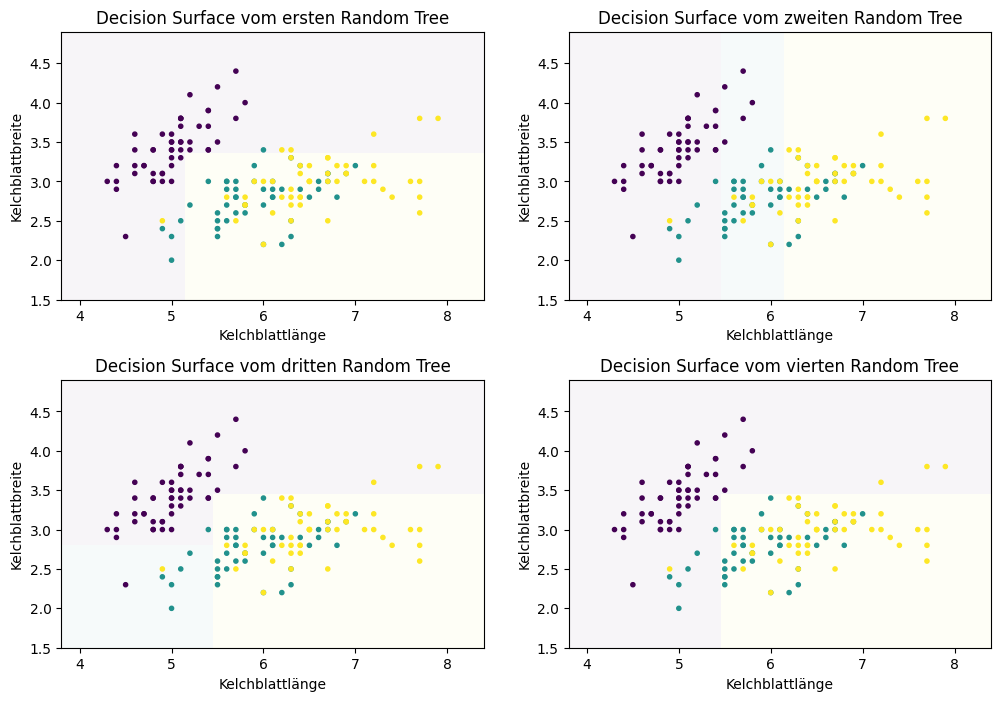

In [10]:
f, axes = plt.subplots(2, 2, figsize=(12, 7))
plot_decision_surface(randomforest.estimators_[0], X, Y, title="Decision Surface vom ersten Random Tree", ax=axes[0,0])
plot_decision_surface(randomforest.estimators_[1], X, Y, title="Decision Surface vom zweiten Random Tree", ax=axes[0,1])
plot_decision_surface(randomforest.estimators_[2], X, Y, title="Decision Surface vom dritten Random Tree", ax=axes[1,0])
plot_decision_surface(randomforest.estimators_[3], X, Y, title="Decision Surface vom vierten Random Tree", ax=axes[1,1])
plt.subplots_adjust(left=None, bottom=0, right=None,
                    top=None, wspace=None, hspace=0.3)
plt.show()

Der erste und der vierte Random Tree sind so schlecht, dass es keine türkise Region gibt. Für sich genommen haben wir also *schwache Klassifikationsmodelle* (engl. *weak classifier*). Wenn wir diese vier schwachen Klassifikationsmodelle durch Mitteln der Vorhersagen kombinieren, bekommen wir ein besseres Ergebnis. 

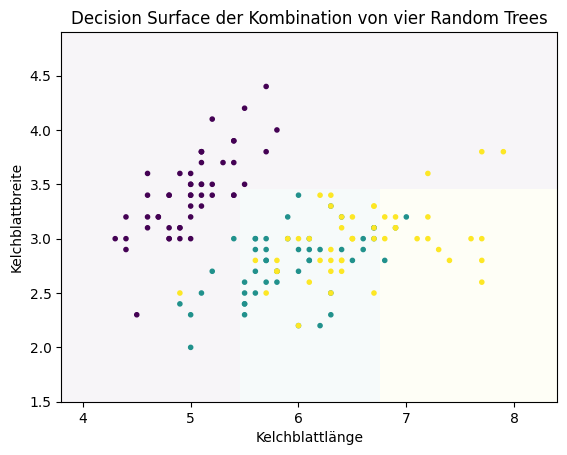

In [11]:
plot_decision_surface(randomforest, X, Y, title="Decision Surface der Kombination von vier Random Trees")
plt.show()

Dass man aus vielen schwachen Modellen ein gutes Ergebnis bekommt, ähnelt dem Prinzip des Publikumsjokers: Wenn man eine zufällige Person fragt, ist die Wahrscheinlichkeit, eine richtige Antwort zu bekommen, niedriger, als wenn man eine Umfrage macht. Genauso verhält es sich auch mit schwachen Klassifikationsmodellen. Jeder der Random Trees ist zwar schlecht, aber jeder Random Tree hat auch Stärken. Zusammengenommen addieren sich die Stärken auf und überdecken dadurch die Schwächen. Üblicherweise nutzt man bei einem Random Forest nicht nur vier Bäume, sondern Hunderte oder sogar Tausende von Bäumen. Hier ist das Ergebnis mit 1000 Random Trees.

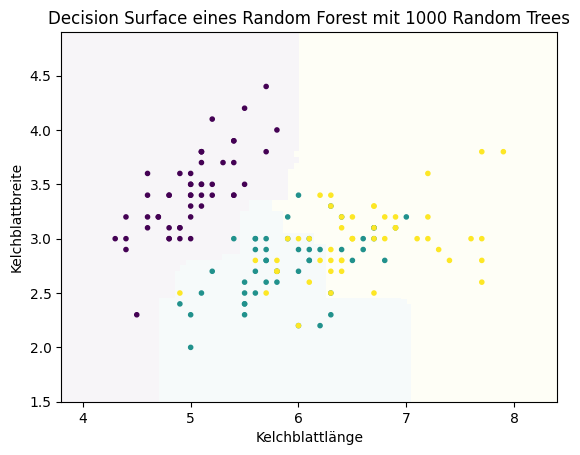

In [12]:
plot_decision_surface(RandomForestClassifier(n_estimators=1000, max_depth=2), X, Y, title="Decision Surface eines Random Forest mit 1000 Random Trees")
plt.show()

Bisher haben wir nur erklärt, wie ein Random Forest aus einem *Ensemble* zu einem einzelnen Ergebnis kommt. Warum wir überhaupt unterschiedliche Entscheidungsbäume für die gleichen Trainingsdaten erhalten, ist noch unklar. Schließlich ist der Algorithmus zum Training von Entscheidungsbäumen deterministisch: Wenn man einen Entscheidungsbaum wie im vorigen Abschnitt zwei Mal mit den gleichen Daten trainiert, bekommt man zwei identische Entscheidungsbäume. Was uns also noch fehlt, ist das Verständnis der Rolle des Zufalls beim Training von Random Forests.

Wenn man sich die einzelnen Random Trees genau anschaut, sieht man bereits einige Hinweise darauf, was randomisiert ist. Hier ist noch einmal der erste der vier Entscheidungsbäume von oben.

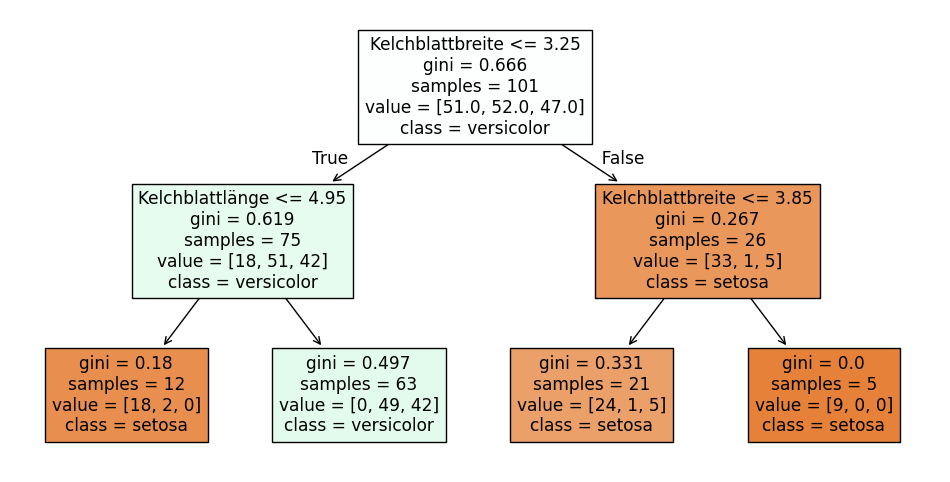

In [13]:
plt.figure(figsize=(12,6))
plot_tree(randomforest.estimators_[0], filled=True, feature_names=X.columns, class_names=class_names)
plt.show()

Man sieht, dass es in der Wurzel des Baums (die erste Entscheidung) nur 101 Instanzen statt der gesamten 150 Instanzen gibt. Außerdem sind nicht von jeder Irisart gleich viele Instanzen vorhanden. Dieser Entscheidungsbaum wurde also offensichtlich nicht mit den originalen Irisdaten trainiert. Was wir hier sehen, ist die erste Randomisierung des Trainings: Als Trainingsdaten bekommt jeder Random Tree ein *Bootstrap Sample* der Daten. Wenn wir 150 Instanzen in den Trainingsdaten haben, heißt das, dass wir 150 Instanzen *mit Zurücklegen* aus den Trainingsdaten ziehen. Da wir mit Zurücklegen ziehen, bekommen wir einige Instanzen mehrfach, andere gar nicht. Im Mittel bekommt man etwa 63,2% verschiedene Instanzen, der Rest sind Duplikate. Alle Random Trees erhalten also andere Trainingsdaten. Bitte beachten Sie, dass `samples` bei einem Random Tree nicht die Anzahl der Instanzen, sondern die Anzahl der Instanzen ohne Duplikate angibt. Das Ziehen von Bootstrap Samples, um mehrere Klassifikationsmodelle zu trainieren, nennt man auch *Bagging*, was die Kurzform für *Bootstrap Aggregating* ist.

Es gibt noch eine weitere zufällige Komponente im Training von Random Forests. Nicht jeder Random Tree erhält alle Merkmale. Stattdessen bekommt jeder Random Tree nur eine Teilmenge der Merkmale zur Verfügung gestellt. Üblicherweise verwendet man die Quadratwurzel der Anzahl der Merkmale pro Baum. Wenn es vier Merkmale gibt, erhält ein Random Tree also nur Zugriff auf $\sqrt{4}=2$ Merkmale. Der Grund hierfür ist, dass sich die Bäume sonst möglicherweise stark ähneln. Wenn ein Merkmal für die gesamten Daten informativ ist, ist es in der Regel auf einem Bootstrap Sample ähnlich informativ. Daher wäre das Risiko groß, dass die Random Trees die gleiche Struktur haben. Wenn nur eine Teilmenge von Merkmalen zur Verfügung steht, haben auch schwächere Merkmale eine Chance, benutzt zu werden und damit ihre Information in den Random Forest einzubringen. So wird sichergestellt, dass die einzelnen Random Trees auch wirklich unterschiedliche Stärken und Schwächen haben.